In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter
import numpy as np

In [3]:
sm_cols = ['09034900', '09035800', '09035900', '09047700', '09065500', '09066000',
       '09066200', '09066300', '09081600', '09107000', '09352900']

### Pull in SNTL Data, basins and closest sntl sites

In [4]:
# UCRB Basins
ucrb_hcdn_basins = gpd.read_file('./ucrb_hcdn_polygons.json')

# Get SNTL data
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)

gdf_sntl = gdf_sntl.to_crs('4326')
nearest_sntl = {}

for i,basin in enumerate(ucrb_hcdn_basins.centroid):
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist_sntl = {r[1]['site_id']: r[1]['geometry'].distance(basin) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')][['site_id','geometry']].iterrows()}
    # get the nearest point index
    idx_sntl = sorted(dist_sntl.items(), key=itemgetter(1))[:2]
    #get the point by index
    nearest_sntl[ucrb_hcdn_basins.iloc[i]['GAGE_ID']] = [site[0] for site in idx_sntl]

# Pull in sntl data
hcdn_sntl_swe_ds = xr.open_dataset('./co_hcdn_sntl_all_20220930.nc')


C:\Users\dlhogan\AppData\Local\Temp\ipykernel_17708\2743736830.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for i,basin in enumerate(ucrb_hcdn_basins.centroid):


In [392]:
# Clean SNTL data
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC']>=0))
hcdn_sntl_swe_ds['PREC'] = hcdn_sntl_swe_ds['PREC'].where((hcdn_sntl_swe_ds['PREC'].diff(dim='Date')<20))

# Open PRISM data

In [5]:
# Download PRISM normals 
outpath = '../../data/PRISM/PRISM_ppt_30yr_normal_800mM4_all_bil/'
files = [x for x in os.listdir(outpath) if (x[-3:] == 'bil') and ('annual' not in x)]
prism_list = []
for file in files:
       prism_list.append(rioxr.open_rasterio(os.path.join(outpath,file)))
prism_normals_ds = xr.concat(prism_list, dim='band')
prism_normals_ds = prism_normals_ds.rename({'band':'month'})

prism_normals_ds = prism_normals_ds.assign_coords({
        'month': [1,2,3,4,5,6,7,8,9,10,11,12]})


### Create SNOTEL Normals Dataset for One Basin

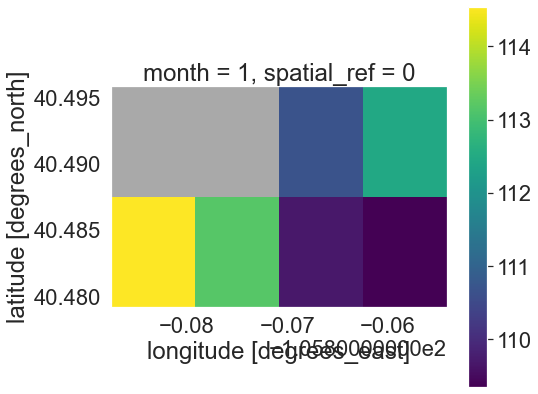

In [417]:
site = 0
tmp_gdf = gpd.GeoDataFrame(ucrb_hcdn_basins.loc[site]).T
basin_prism = prism_normals_ds.rio.clip(tmp_gdf.geometry)
basin_prism = basin_prism.where(basin_prism>=0)

# Create a quick example plot of where the nearest SNTL is on the PRISM data
fig, ax = plt.subplots(figsize=(8,6),tight_layout=True)
basin_prism.sel(month=1).plot(ax=ax)
gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['GAGE_ID']][0]].plot(ax=ax);
gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[ucrb_hcdn_basins.loc[site]['GAGE_ID']][1]].plot(ax=ax);


In [6]:
def single_hcdn_basin_prism_precip(site_no):
    """Get the basin prism precip values derived from method used in Raleigh and Lundquist 2012. Grabs nearest SNTL data to build a SNTL weight
    is then applied to the remaining cells within the basin. This value is also compared to the second closest snotels and flags sites where these
    SNOTELs have very different values.     

    Args:
        site_no (string or int): USGS gage site number 

    Returns:
        ds: xarray dataset containing monthly precip derived from SNTL and PRISM normals
    """
    if type(site_no) is str:
        tmp_gdf = ucrb_hcdn_basins[ucrb_hcdn_basins['GAGE_ID']==site_no]
        sntl_id = nearest_sntl[site_no][0]
        sntl_id2 = nearest_sntl[site_no][1]
        x1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][0]].geometry.x.values
        y1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][0]].geometry.y.values
        x2 =gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][1]].geometry.x.values
        y2 =gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[site_no][1]].geometry.y.values
        
    else:
        tmp_gdf = gpd.GeoDataFrame(ucrb_hcdn_basins.loc[site_no]).T
        sntl_id = nearest_sntl[ucrb_hcdn_basins.loc[site_no]['GAGE_ID']][0]
        sntl_id2 = nearest_sntl[ucrb_hcdn_basins.loc[site_no]['GAGE_ID']][1]
        x1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id]].geometry.x.values
        y1 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id]].geometry.y.values
        x2 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id2]].geometry.x.values
        y2 = gdf_sntl[gdf_sntl['site_id'] == nearest_sntl[sntl_id2]].geometry.y.values
        
    tmp_gdf = tmp_gdf.set_crs('4326')
    
    basin_prism = prism_normals_ds.rio.clip(tmp_gdf.geometry)
    basin_prism = basin_prism.where(basin_prism>=0)

    # Get sntl PRISM value

    if not tmp_gdf.set_crs(4326).reset_index().contains(gdf_sntl[gdf_sntl['site_id'] == sntl_id].reset_index()).values:
        print('Nearest SNTL is not in basin!')

    nearest_sntl_prism_val = prism_normals_ds.sel(x=x1, method='nearest').sel(y=y1, method='nearest').squeeze()
    second_sntl_prism_val = prism_normals_ds.sel(x=x2, method='nearest').sel(y=y2, method='nearest').squeeze()
    
    if abs((nearest_sntl_prism_val/second_sntl_prism_val).std()) > 1:
        print('Check SNOTEL site choice, two closest SNTLs are very different')
    
    # Create prism multiplier
    prism_multiplier = basin_prism/nearest_sntl_prism_val

    # Get monthly precip from SNOTEL
    single_site = hcdn_sntl_swe_ds.sel(Location=sntl_id).dropna(dim='Date')
    time_first = single_site.resample(Date='1M').first()['PREC']
    time_last = single_site.resample(Date='1M').last()['PREC']
    sntl_monthly_precip1 = (time_last - time_first) * 10 # convert to mm
    # Get monthly precip from SNOTEL
    second_site = hcdn_sntl_swe_ds.sel(Location=sntl_id2).dropna(dim='Date')
    time_first = second_site.resample(Date='1M').first()['PREC']
    time_last = second_site.resample(Date='1M').last()['PREC']
    sntl_monthly_precip2 = (time_last - time_first) * 10 # convert to mm

    sntl_monthly_precip = xr.concat([sntl_monthly_precip2,sntl_monthly_precip1], dim='time').mean(dim='time', skipna=True)
    # Create list for monthly prism datasets
    monthly_prism = []
    for mo in np.arange(1,13,1):
        tmp_ds = prism_multiplier.sel(month=mo) * sntl_monthly_precip.where(sntl_monthly_precip.Date.dt.month==mo)
        tmp_ds.name = site_no
        tmp_ds = tmp_ds.to_dataframe().dropna().to_xarray()
        monthly_prism.append(tmp_ds)
    ds = xr.concat(monthly_prism,dim='Date').sortby('Date')
    ds = ds.assign_coords({'WY':ds.Date.dt.year.where(ds.Date.dt.month < 10, ds.Date.dt.year + 1)})
    return ds[['WY',site_no]]

In [7]:
def get_monthly_prism_anomalies(ds):
    # Get monthly normalized values of sublimation/evaporation and precipitation
    ds_mean = ds.groupby('Date.month').mean("Date")
    ds_std = ds.groupby('Date.month').std("Date")

    stand_anomalies = xr.apply_ufunc(
        lambda x,m,s: (x-m)/s,
        ds.groupby("Date.month"),
        ds_mean,
        ds_std,
        dask='parallelized'
    )
    return stand_anomalies

In [8]:
# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(XTIME)
    month_length = ds.Date.dt.days_in_month

    # Calculate the weighted average
    return (ds * month_length).resample(Date='QS-DEC').sum() / month_length.resample(Date='QS-DEC').sum()

In [9]:
seasonal_prisms_list = []
for site in nearest_sntl.keys():
    if site in sm_cols:
        # Get site ID
        site_id = site
        print(f'Working on {site_id}')
        # Generate prism dataset
        ds = single_hcdn_basin_prism_precip(site_id)
        # Create basin average precip for prism
        prism_basin_avg = ds.mean(dim='x',skipna=True).mean(dim='y', skipna=True)
        # Get seasonal anaomalies
        seasonal_prism = season_mean(get_monthly_prism_anomalies(prism_basin_avg)).to_dataframe().dropna()
        # add to list
        seasonal_prisms_list.append(seasonal_prism)

Working on 09034900
Nearest SNTL is not in basin!
Working on 09035800
Nearest SNTL is not in basin!
Working on 09035900
Nearest SNTL is not in basin!
Working on 09047700
Nearest SNTL is not in basin!
Working on 09065500
Nearest SNTL is not in basin!
Working on 09066000
Nearest SNTL is not in basin!
Working on 09066200
Nearest SNTL is not in basin!
Working on 09066300
Nearest SNTL is not in basin!
Working on 09081600
Working on 09107000
Working on 09352900
Nearest SNTL is not in basin!


In [10]:
hcdn_season_prism_ds = pd.concat(seasonal_prisms_list, axis=1)
hcdn_season_prism_ds['WY'] = hcdn_season_prism_ds.index.year.where(hcdn_season_prism_ds.index.month<10, hcdn_season_prism_ds.index.year+1)

In [11]:
hcdn_spring_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==6].set_index('WY', drop=True)
hcdn_summer_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==9].set_index('WY', drop=True)
hcdn_fall_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==12].set_index('WY', drop=True)
hcdn_winter_precip = hcdn_season_prism_ds[hcdn_season_prism_ds.index.month==3].set_index('WY', drop=True)


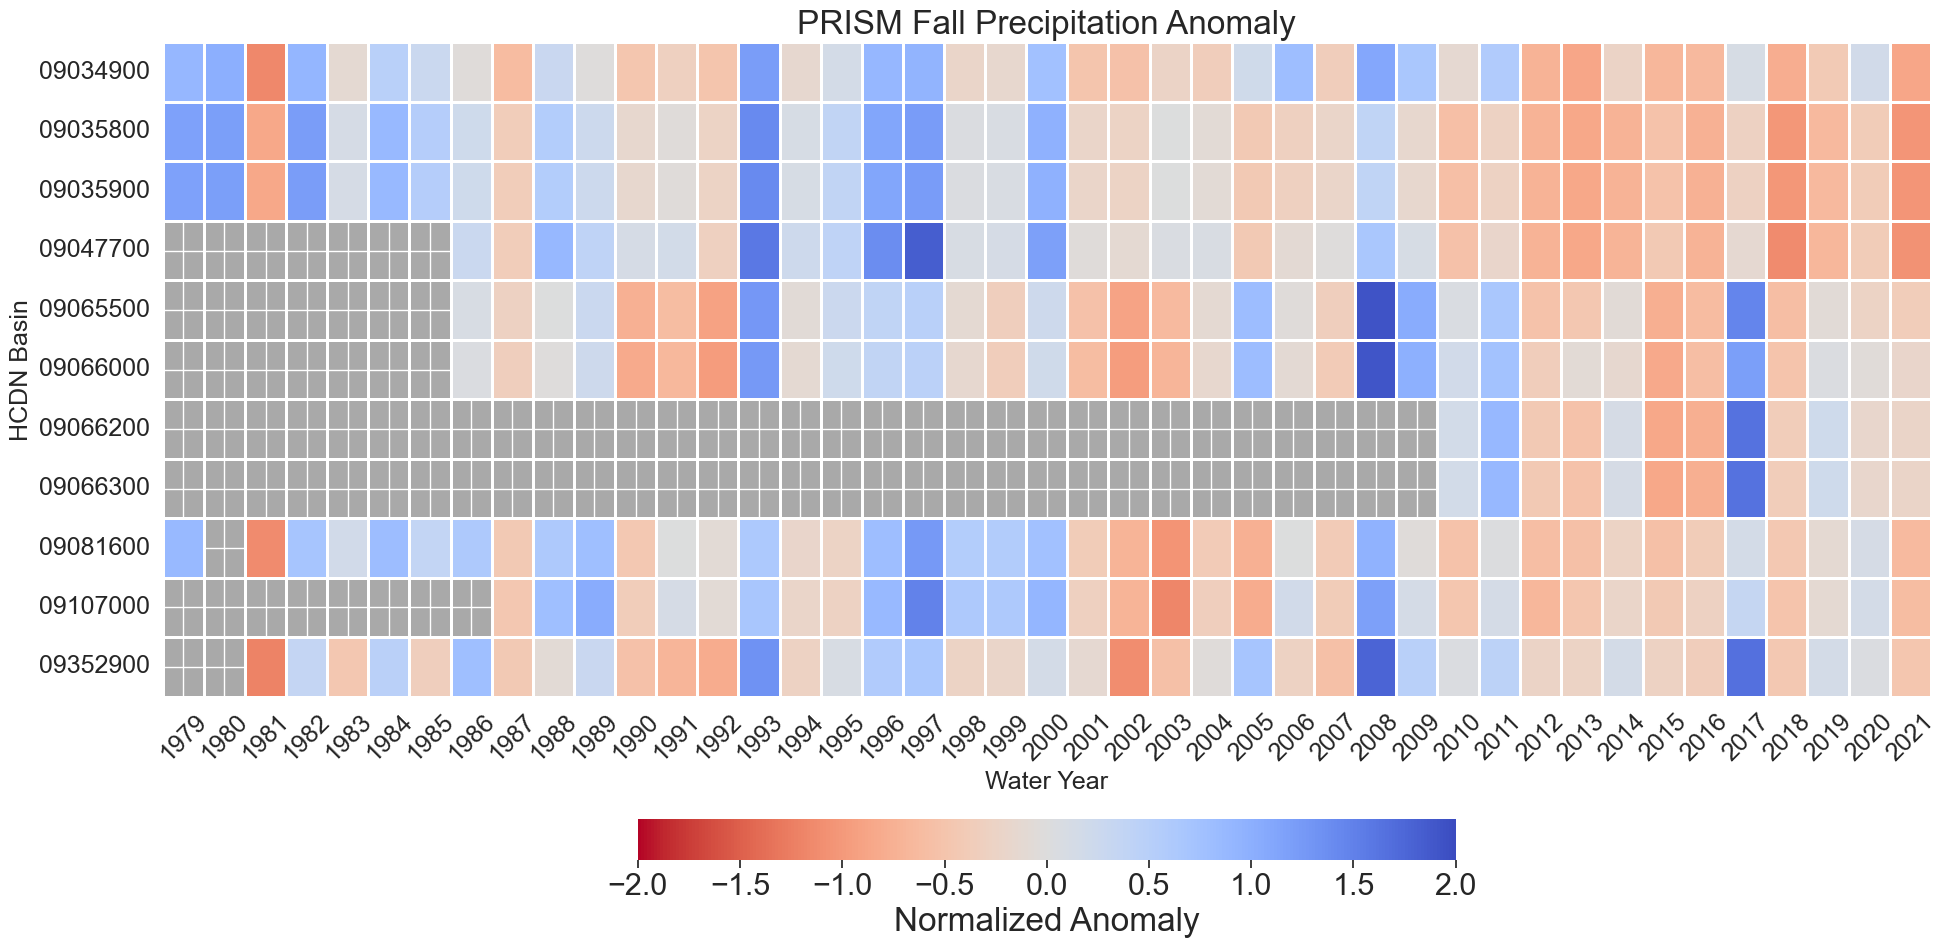

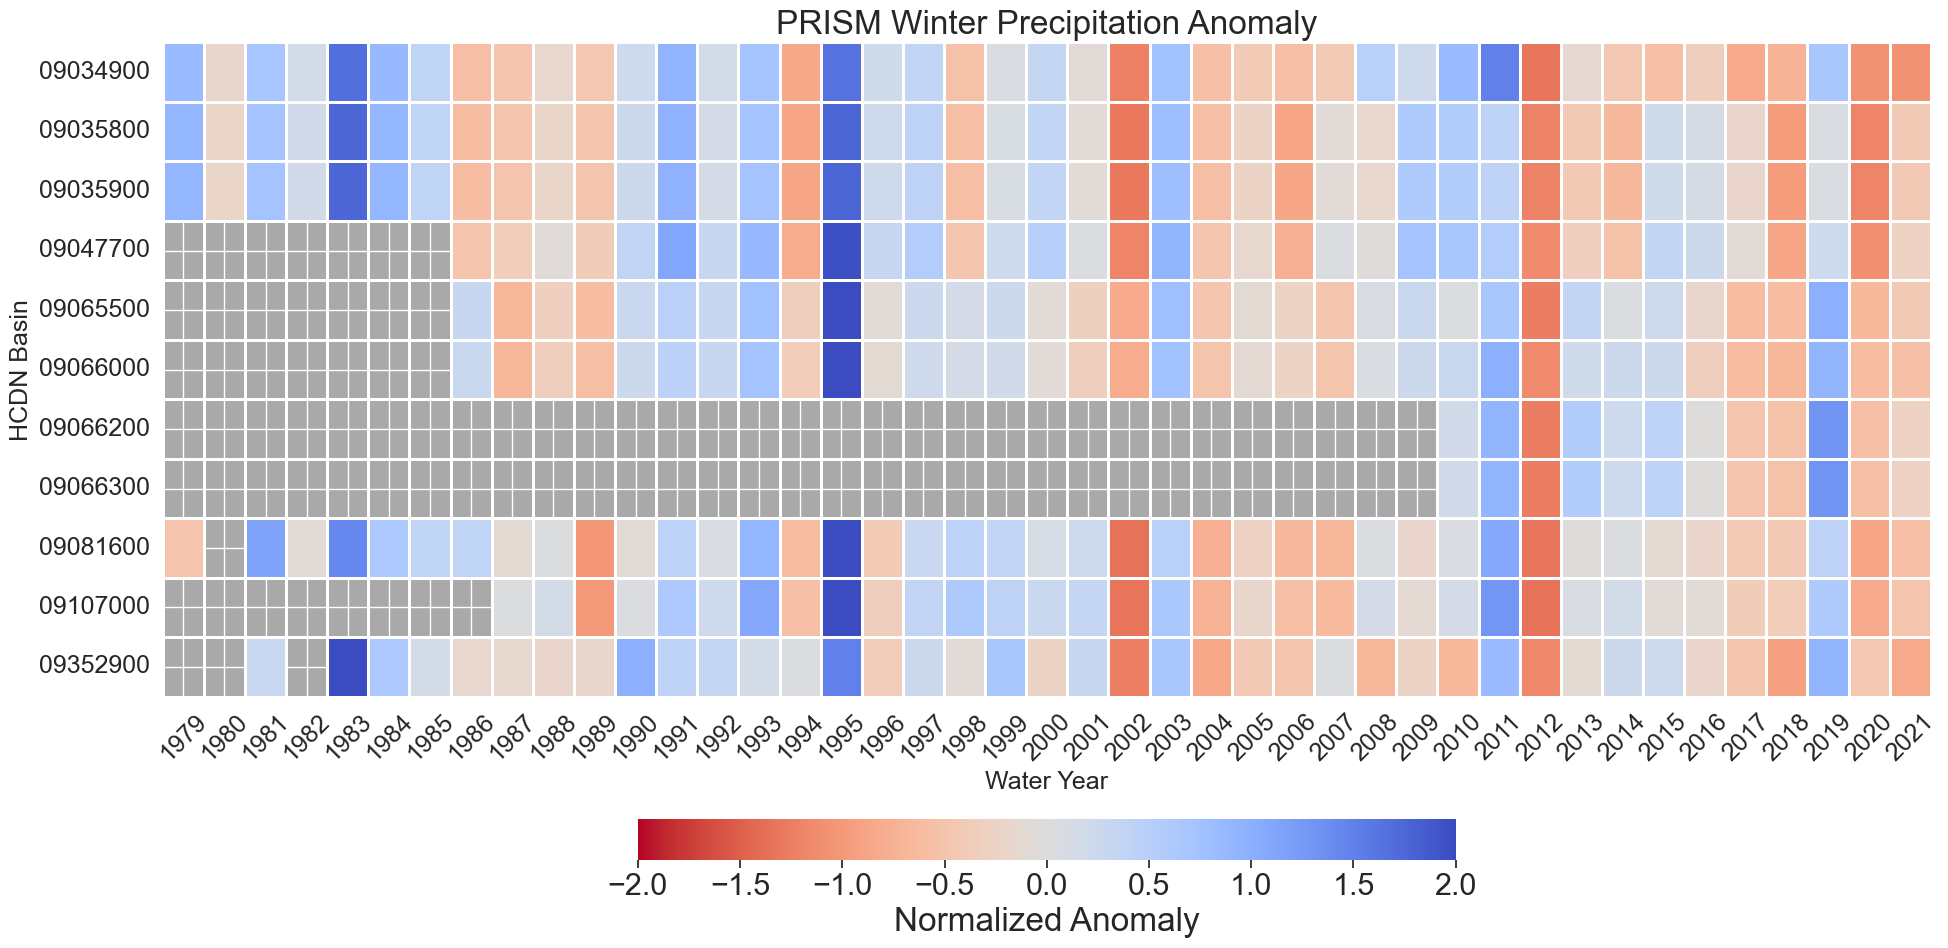

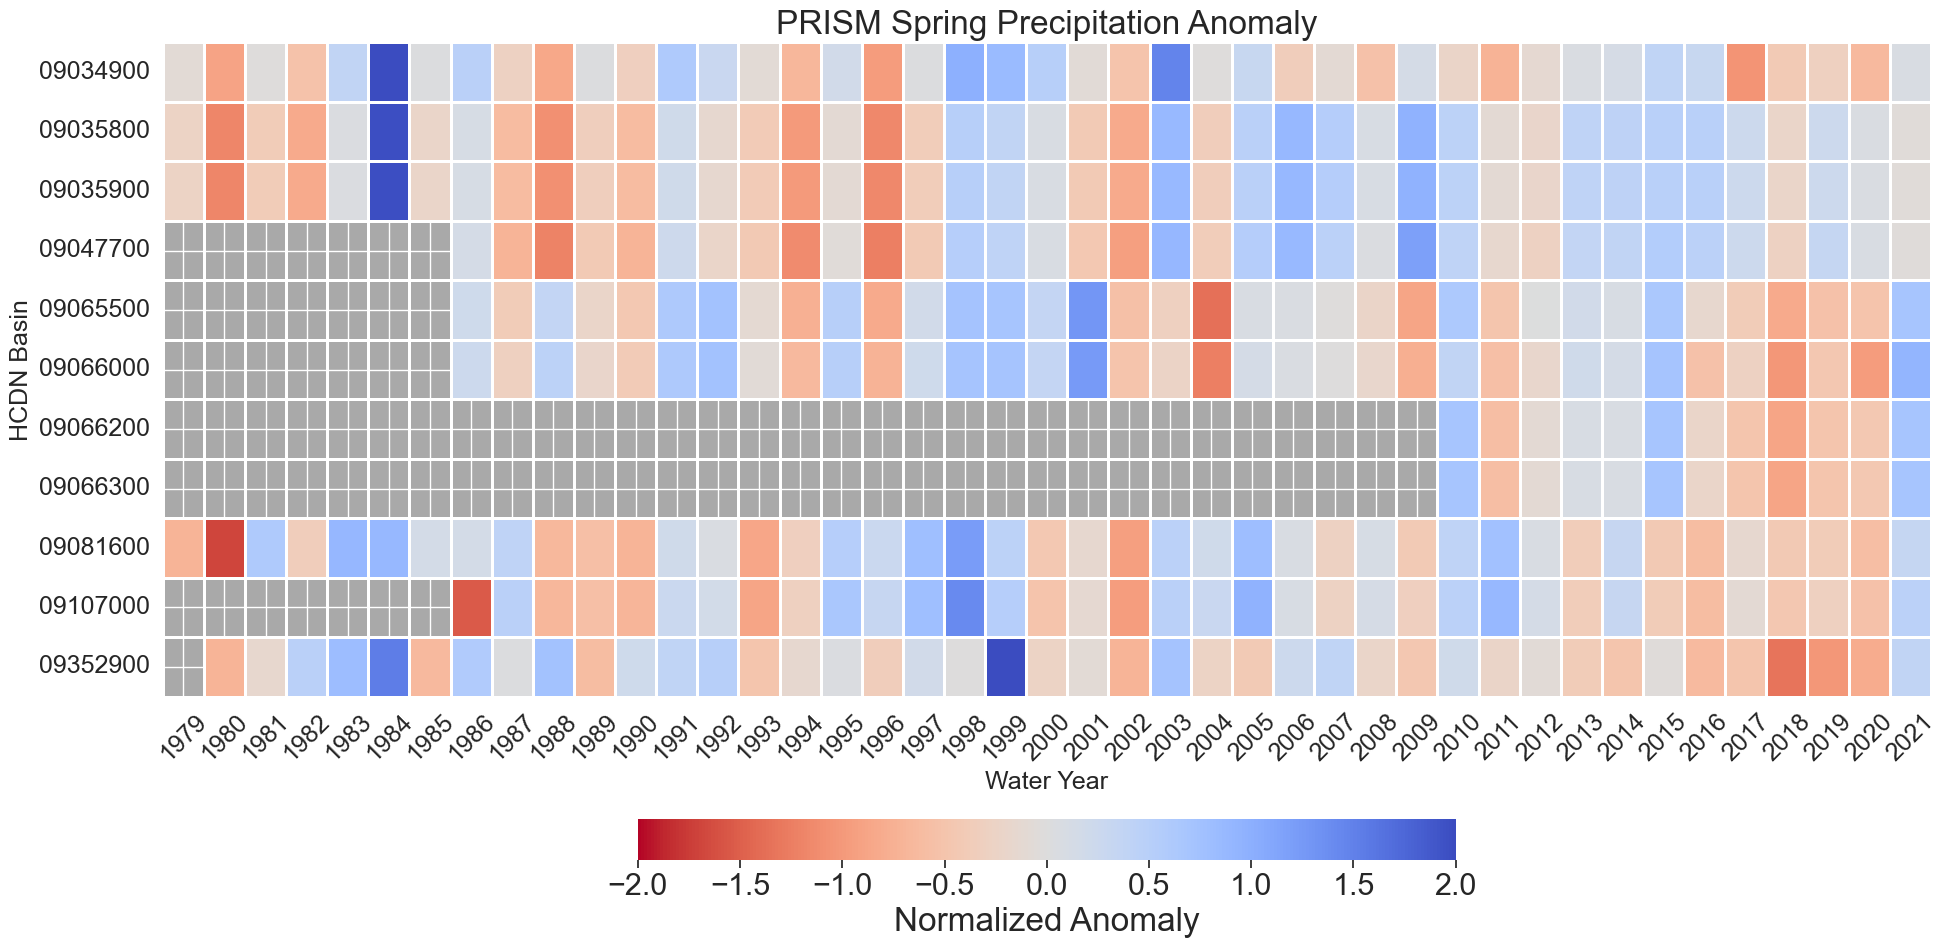

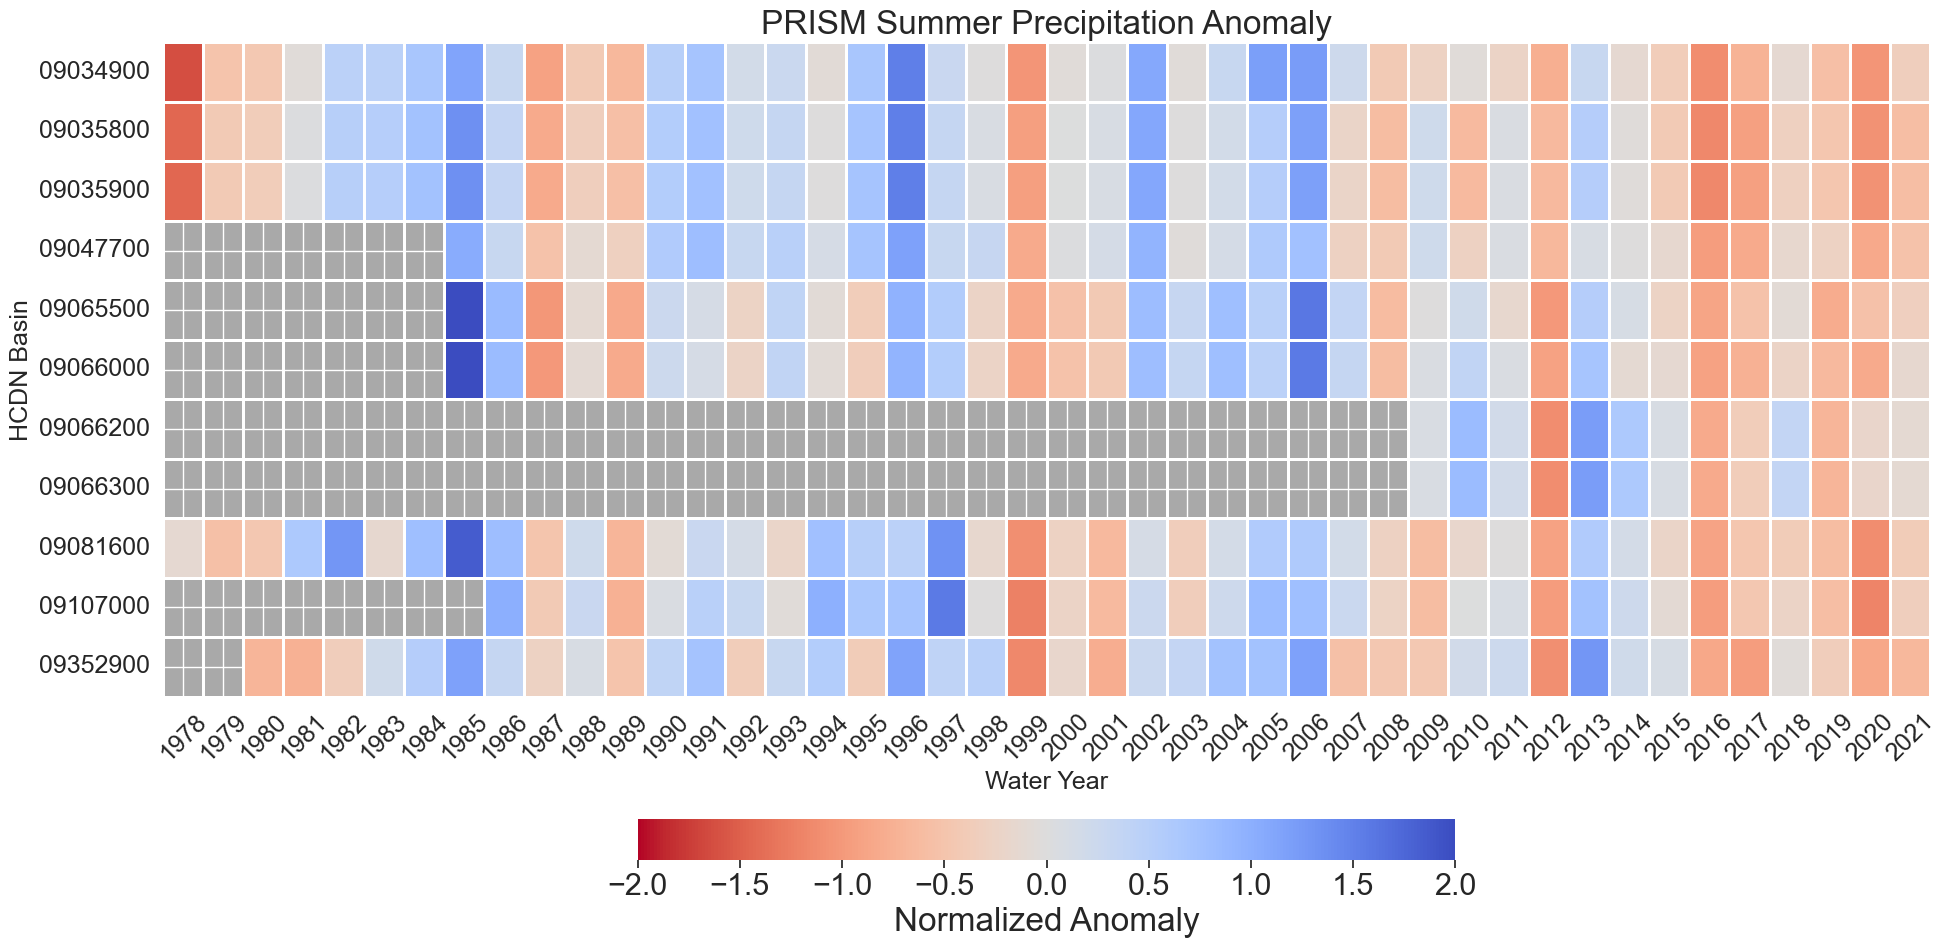

In [12]:
sns.set(font_scale=2, rc={'axes.facecolor':'darkgrey'})
labels = ['Fall','Winter','Spring','Summer']

for i,df in enumerate([hcdn_fall_precip, hcdn_winter_precip, hcdn_spring_precip, hcdn_summer_precip]):
    fig, ax=plt.subplots(nrows=1,figsize=(20,10), facecolor='w',tight_layout=True)
    df_transpose = df.iloc[:-1].T
    sns.heatmap(df_transpose, 
                cmap='coolwarm_r', 
                vmin=-2, 
                vmax=2,
                linewidths=2, 
                cbar_kws={'label':'Normalized Anomaly',
                        'orientation':'horizontal',
                        'fraction':.05},
                ax=ax)
    ax.set_yticklabels(df_transpose.index, rotation=0, ha='right', size=18);
    ax.set_xticklabels(df_transpose.columns, rotation=45, ha='center', size=18);
    ax.set_ylabel('HCDN Basin',size=18)
    ax.set_xlabel('Water Year', size=18)
    ax.set_title(f'PRISM {labels[i]} Precipitation Anomaly', size=24)
